# Feature Engineering Macro Data and Final Classification Model

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from info_gain import info_gain
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/combined/combined.csv')

In [3]:
df.head(10)

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,sentiments,target
0,15278.919000,199.4,4.8,135737.0,177887.0,8.387451e+06,12.34,2.532629e-07,0.442418,0.098614,1.488264e-01,0.021148,0.288993,-0.1,1
1,15290.812000,199.7,4.7,136047.0,178100.0,8.403747e+06,11.39,5.791823e-07,0.013136,0.000042,9.707158e-01,0.002117,0.013989,0.0,1
2,15302.705000,200.7,4.7,136205.0,178088.0,8.420042e+06,11.59,2.570856e-07,0.388304,0.011189,4.659097e-01,0.011551,0.123046,0.0,-1
3,15310.592667,201.3,4.6,136244.0,177200.0,8.449019e+06,16.44,2.403132e-07,0.492659,0.050694,1.158198e-01,0.125781,0.215045,0.0,1
4,15318.480333,201.8,4.6,136325.0,177343.0,8.477997e+06,13.08,1.027025e-06,0.005665,0.000001,9.923208e-01,0.000148,0.001864,0.6,0
5,15326.368000,202.9,4.7,136520.0,176937.0,8.506974e+06,14.95,3.974326e-07,0.073057,0.349738,3.974326e-07,0.087838,0.489367,0.0,1
6,15369.888000,203.8,4.7,136694.0,176983.0,8.564724e+06,12.31,3.292580e-07,0.602091,0.044666,4.766647e-02,0.049294,0.256283,0.0,0
7,15413.408000,202.8,4.5,136843.0,177002.0,8.622474e+06,11.98,2.579949e-07,0.076280,0.121305,1.086829e-02,0.048339,0.743207,0.1,1
8,15456.928000,201.9,4.4,136852.0,177544.0,8.680224e+06,11.10,1.209156e-06,0.057376,0.018356,8.510057e-01,0.011598,0.061663,-0.3,-1
9,15469.061333,202.0,4.5,137063.0,177854.0,8.736704e+06,10.91,4.024654e-07,0.127895,0.173201,1.495148e-05,0.348323,0.350566,-0.1,0


## Feature Engineering Macro Data

In [4]:
df.columns

Index(['GDPC1', 'CPIAUCSL', 'UNRATE', 'PAYEMS', 'RRSFS', 'GFDEBTN', 'VIXCLS',
       'prob_topic_1', 'prob_topic_2', 'prob_topic_3', 'prob_topic_4',
       'prob_topic_5', 'prob_topic_6', 'sentiments', 'target'],
      dtype='object')

In [5]:
df.head()

,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,sentiments,target
0,15278.919000,199.4,4.8,135737.0,177887.0,8.387451e+06,12.34,2.532629e-07,0.442418,0.098614,0.148826,0.021148,0.288993,-0.1,1
1,15290.812000,199.7,4.7,136047.0,178100.0,8.403747e+06,11.39,5.791823e-07,0.013136,0.000042,0.970716,0.002117,0.013989,0.0,1
2,15302.705000,200.7,4.7,136205.0,178088.0,8.420042e+06,11.59,2.570856e-07,0.388304,0.011189,0.465910,0.011551,0.123046,0.0,-1
3,15310.592667,201.3,4.6,136244.0,177200.0,8.449019e+06,16.44,2.403132e-07,0.492659,0.050694,0.115820,0.125781,0.215045,0.0,1
4,15318.480333,201.8,4.6,136325.0,177343.0,8.477997e+06,13.08,1.027025e-06,0.005665,0.000001,0.992321,0.000148,0.001864,0.6,0


In [6]:
macro_columns = ['GDPC1',
                'CPIAUCSL',
                'UNRATE',
                'PAYEMS',
                'RRSFS',
                'GFDEBTN',
                'VIXCLS']

In [7]:
for col in macro_columns:
    # percentage difference
    diff = (df[col].diff() / df[col].shift(1)) * 100
    diff_idx = df.columns.get_loc(col) + 1
    
    df.insert(loc=diff_idx, column=f'{col}_diff', value=diff)
    
    # simple moving averages (SMA 3, 5)
    sma_3 = df[col].rolling(window=3).mean()
    sma_5 = df[col].rolling(window=5).mean()
    sma_3_idx = diff_idx + 1
    sma_5_idx = sma_3_idx + 1
    
    df.insert(loc=sma_3_idx, column=f'{col}_sma_3', value=sma_3)
    df.insert(loc=sma_5_idx, column=f'{col}_sma_5', value=sma_5)
    
    # exponential weighted moving average
    ewm = df[col].ewm(span=40, adjust=False).mean()
    ewm_idx = sma_5_idx + 1
    
    df.insert(loc=ewm_idx, column=f'{col}_ewm', value=ewm)
    
df = df.dropna().reset_index(drop=True)

In [8]:
final_df = df

In [9]:
final_df

,GDPC1,GDPC1_diff,GDPC1_sma_3,GDPC1_sma_5,GDPC1_ewm,CPIAUCSL,CPIAUCSL_diff,CPIAUCSL_sma_3,CPIAUCSL_sma_5,CPIAUCSL_ewm,...,VIXCLS_sma_5,VIXCLS_ewm,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,sentiments,target
0,15318.480333,0.051518,15310.592667,15300.301800,15283.867685,201.800,0.248385,201.266667,200.5800,199.675209,...,12.968,12.493353,1.027025e-06,0.005665,0.000001,9.923208e-01,0.000148,1.864488e-03,0.6,0
1,15326.368000,0.051491,15318.480333,15309.791600,15285.940871,202.900,0.545094,202.000000,201.2800,199.832516,...,13.490,12.613190,3.974326e-07,0.073057,0.349738,3.974326e-07,0.087838,4.893666e-01,0.0,1
2,15369.888000,0.283955,15338.245444,15325.606800,15290.035853,203.800,0.443568,202.833333,202.1000,200.026052,...,13.674,12.598400,3.292580e-07,0.602091,0.044666,4.766647e-02,0.049294,2.562828e-01,0.0,0
3,15413.408000,0.283151,15369.888000,15347.747400,15296.054006,202.800,-0.490677,203.166667,202.5200,200.161366,...,13.752,12.568234,2.579949e-07,0.076280,0.121305,1.086829e-02,0.048339,7.432073e-01,0.1,1
4,15456.928000,0.282352,15413.408000,15377.014467,15303.901518,201.900,-0.443787,202.833333,202.6400,200.246178,...,12.684,12.496613,1.209156e-06,0.057376,0.018356,8.510057e-01,0.011598,6.166330e-02,-0.3,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,18794.426000,0.352236,18728.457667,18589.415667,18506.105806,260.462,0.120316,260.040667,259.2016,253.480113,...,29.138,21.758281,8.155466e-07,0.001263,0.277596,7.188678e-01,0.000778,1.493741e-03,0.1,0
173,18794.426000,0.000000,18772.436556,18715.264000,18520.170206,260.927,0.178529,260.512667,259.9306,253.843375,...,27.166,21.700316,7.587675e-07,0.001052,0.233172,7.633303e-01,0.000944,1.501466e-03,0.1,0
174,18794.426000,0.000000,18794.426000,18754.845000,18533.548537,261.560,0.242597,260.983000,260.5218,254.219796,...,26.824,21.751520,8.281763e-07,0.000082,0.501833,4.979199e-01,0.000163,8.281763e-07,0.1,0
175,18794.426000,0.000000,18794.426000,18781.232333,18546.274267,262.231,0.256538,261.572667,261.0658,254.610587,...,28.160,22.304617,1.981140e-06,0.000002,0.000002,9.999901e-01,0.000002,1.981140e-06,0.3,-1


In [10]:
final_df.columns

Index(['GDPC1', 'GDPC1_diff', 'GDPC1_sma_3', 'GDPC1_sma_5', 'GDPC1_ewm',
       'CPIAUCSL', 'CPIAUCSL_diff', 'CPIAUCSL_sma_3', 'CPIAUCSL_sma_5',
       'CPIAUCSL_ewm', 'UNRATE', 'UNRATE_diff', 'UNRATE_sma_3', 'UNRATE_sma_5',
       'UNRATE_ewm', 'PAYEMS', 'PAYEMS_diff', 'PAYEMS_sma_3', 'PAYEMS_sma_5',
       'PAYEMS_ewm', 'RRSFS', 'RRSFS_diff', 'RRSFS_sma_3', 'RRSFS_sma_5',
       'RRSFS_ewm', 'GFDEBTN', 'GFDEBTN_diff', 'GFDEBTN_sma_3',
       'GFDEBTN_sma_5', 'GFDEBTN_ewm', 'VIXCLS', 'VIXCLS_diff', 'VIXCLS_sma_3',
       'VIXCLS_sma_5', 'VIXCLS_ewm', 'prob_topic_1', 'prob_topic_2',
       'prob_topic_3', 'prob_topic_4', 'prob_topic_5', 'prob_topic_6',
       'sentiments', 'target'],
      dtype='object')

In [53]:
final_df.to_csv('../data/combined/final_combined.csv', index=False)

### Normalising Features

In [11]:
train_size = int(len(final_df) * 0.7)
train, test = final_df[0:train_size], final_df[train_size:len(final_df)]
print('Observations: %d' % (len(final_df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 177
Training Observations: 123
Testing Observations: 54


In [12]:
X_train = train.iloc[:,:-1]
X_test = test.iloc[:,:-1]
y_train = train.target
y_test = test.target

In [13]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_norm = (X_train - X_train_mean)/X_train_std
X_test_norm = (X_test - X_train_mean)/X_train_std

In [14]:
X_train_norm.describe()

,GDPC1,GDPC1_diff,GDPC1_sma_3,GDPC1_sma_5,GDPC1_ewm,CPIAUCSL,CPIAUCSL_diff,CPIAUCSL_sma_3,CPIAUCSL_sma_5,CPIAUCSL_ewm,...,VIXCLS_sma_3,VIXCLS_sma_5,VIXCLS_ewm,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_4,prob_topic_5,prob_topic_6,sentiments
count,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,...,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02
mean,2.938932e-15,3.610481e-17,-4.393956e-15,-4.924697e-15,1.610997e-14,2.337787e-15,1.779290e-16,6.007841e-15,-1.931608e-15,3.830721e-15,...,1.375593e-15,-7.518827e-16,-4.440892e-16,4.986977e-17,-2.581494e-16,-1.918068e-18,-2.527337e-17,-2.938029e-16,-3.068909e-17,5.156219e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.325272e+00,-3.957918e+00,-1.307709e+00,-1.293201e+00,-1.050821e+00,-1.898874e+00,-5.781356e+00,-1.906663e+00,-1.926311e+00,-1.603371e+00,...,-1.166824e+00,-1.200156e+00,-1.665218e+00,-4.652924e-01,-5.260346e-01,-8.577657e-01,-8.478680e-01,-3.113773e-01,-6.435751e-01,-2.481083e+00
25%,-7.749100e-01,-3.607971e-01,-7.792715e-01,-7.767090e-01,-7.827909e-01,-7.805973e-01,-3.683318e-01,-7.976393e-01,-7.553701e-01,-7.844002e-01,...,-6.843817e-01,-7.190111e-01,-6.815095e-01,-4.196454e-01,-5.191963e-01,-8.491483e-01,-8.327153e-01,-3.113484e-01,-6.375310e-01,-6.894596e-01
50%,-4.521772e-01,2.281340e-01,-4.342229e-01,-4.244525e-01,-5.127254e-01,1.373772e-01,1.251279e-01,1.303327e-01,1.084005e-01,-6.302549e-02,...,-2.938719e-01,-2.746318e-01,-2.342647e-01,-3.612526e-01,-4.879295e-01,-5.346854e-01,-6.571986e-01,-2.893754e-01,-5.780488e-01,-9.225163e-02
75%,6.249940e-01,6.352790e-01,6.204109e-01,6.493936e-01,6.281550e-01,9.678002e-01,4.992144e-01,9.834840e-01,9.645524e-01,9.292324e-01,...,3.649747e-01,3.965966e-01,9.580642e-01,1.486524e-01,-2.400725e-01,8.847120e-01,1.341136e+00,-2.002591e-01,1.703889e-01,5.049563e-01
max,2.045324e+00,1.520585e+00,2.052790e+00,2.064375e+00,2.367356e+00,1.444824e+00,2.722804e+00,1.442264e+00,1.426887e+00,1.564547e+00,...,3.763640e+00,3.660825e+00,1.519880e+00,6.919753e+00,3.133376e+00,1.792451e+00,1.450378e+00,6.564995e+00,3.720294e+00,3.490996e+00


### Feature Selection

#### Variance Inflation Factor

In [15]:
def cal_vif(x):
    thresh = 5
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1, k):
        print('Iteration no ', i)
        print(vif)
        a = np.argmax(vif)
        print('Max vif ', a)
        if vif[a] <= thresh:
            break
        if i == 1:
            output = x.drop(x.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1:
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return output

x = pd.DataFrame(X_train)
selected_features = cal_vif(x)
selected_features.head()

Iteration no  1
[50788.05130098888, 54.75113418893287, 97059.81875254618, 17297.323391055674, 10255.371102609442, 9201.882393409569, 21.20524940755435, 17714.153296775523, 4233.011717621155, 10088.876549557694, 1759.660441802024, 6.409145121593852, 4181.417800546506, 4179.233132403786, 13973.46693462737, 29844.51811069243, 50.78957061937497, 61288.277758072974, 15137.300713022358, 8406.50358230519, 1419.572573990406, 8.76775910592134, 2710.1888488752716, 2010.6401149014584, 4830.726540660912, 123054.92953266333, 30.554242259761562, 265406.72712413885, 77182.3531299318, 54101.02148901286, 24.36194010743109, 3.588114129344087, 63.84142909412429, 60.348593616949934, 614.4351336960598, 1.7864970285760498, 1675015.1642221236, 4622058.728738897, 6145668.7313832715, 135560.93919591882, 1354911.658932107, 1.6372278982484931]
Max vif  38
Iteration no  2
[21044701.318301845, 70.48673466503739, 40695889.16608396, 7329498.107604425, 8187344.222499922, 3452518.1808063504, 25.316951408894663, 657315

Iteration no  13
[71488.26726682081, 4.204765223387073, 257732.35875025394, 5.0868469940809256, 334797.5212828049, 22228.78034092526, 6.009037017613296, 57263.9228426266, 23890.66011672799, 4436.021979832543, 10.367778832902333, 138811.30343181602, 3.8289526669505656, 200370.6807166838, 79731.8583314679, 114836.30857824364, 23.976438272603676, 197008.82457095452, 37827.11774961797, 121.24401860158306, 3.246870038939072, 358.57222980463985, 392.47573538754426, 3964.7955255055563, 2.158737504967997, 3.214881223713947, 4.001762010369362, 1.4984078231309652, 2.5225042813429135, 1.4716691114126068]
Max vif  4
Iteration no  14
[66576.25322076169, 4.128707382191343, 24189.711695091348, 2.6688086679859677, 22018.435025635015, 5.98589232034549, 56051.87793902091, 23834.07627541637, 3710.4219310247095, 10.125266679774835, 130140.57753479536, 3.556186619038532, 199499.64509302107, 61612.66176216645, 113446.50566743172, 23.778625973576908, 186243.09750359852, 34485.37283428746, 120.30536344207351,

,GDPC1_diff,CPIAUCSL_diff,UNRATE_diff,PAYEMS_diff,RRSFS_diff,GFDEBTN_diff,VIXCLS_diff,prob_topic_1,prob_topic_2,prob_topic_3,prob_topic_5,prob_topic_6,sentiments
0,0.051518,0.248385,0.000000,0.059452,0.080700,0.342967,-20.437956,1.027025e-06,0.005665,0.000001,0.000148,0.001864,0.6
1,0.051491,0.545094,2.173913,0.143041,-0.228935,0.341795,14.296636,3.974326e-07,0.073057,0.349738,0.087838,0.489367,0.0
2,0.283955,0.443568,0.000000,0.127454,0.025998,0.678855,-17.658863,3.292580e-07,0.602091,0.044666,0.049294,0.256283,0.0
3,0.283151,-0.490677,-4.255319,0.109003,0.010735,0.674277,-2.680747,2.579949e-07,0.076280,0.121305,0.048339,0.743207,0.1
4,0.282352,-0.443787,-2.222222,0.006577,0.306211,0.669761,-7.345576,1.209156e-06,0.057376,0.018356,0.011598,0.061663,-0.3


#### Random Forest Feature Importance

In [16]:
rf_clf = RandomForestClassifier(random_state=1).fit(X_train, y_train)

In [17]:
rf_clf.feature_importances_

array([0.01887643, 0.03187316, 0.02584207, 0.01891701, 0.0265119 ,
       0.02859545, 0.03130962, 0.025794  , 0.02282973, 0.03387435,
       0.01507576, 0.02349985, 0.01921136, 0.01312744, 0.01504527,
       0.01511864, 0.02701504, 0.01633651, 0.01700133, 0.01891536,
       0.04445868, 0.03170173, 0.02690843, 0.02175969, 0.01233317,
       0.02574408, 0.02453793, 0.02382569, 0.02586225, 0.01309835,
       0.03178833, 0.03851774, 0.02536445, 0.02535225, 0.0126254 ,
       0.00972998, 0.02567034, 0.02368667, 0.02848003, 0.02200435,
       0.03921507, 0.02256512])

In [18]:
importance = rf_clf.feature_importances_

Feature: 0, Score: 0.01888
Feature: 1, Score: 0.03187
Feature: 2, Score: 0.02584
Feature: 3, Score: 0.01892
Feature: 4, Score: 0.02651
Feature: 5, Score: 0.02860
Feature: 6, Score: 0.03131
Feature: 7, Score: 0.02579
Feature: 8, Score: 0.02283
Feature: 9, Score: 0.03387
Feature: 10, Score: 0.01508
Feature: 11, Score: 0.02350
Feature: 12, Score: 0.01921
Feature: 13, Score: 0.01313
Feature: 14, Score: 0.01505
Feature: 15, Score: 0.01512
Feature: 16, Score: 0.02702
Feature: 17, Score: 0.01634
Feature: 18, Score: 0.01700
Feature: 19, Score: 0.01892
Feature: 20, Score: 0.04446
Feature: 21, Score: 0.03170
Feature: 22, Score: 0.02691
Feature: 23, Score: 0.02176
Feature: 24, Score: 0.01233
Feature: 25, Score: 0.02574
Feature: 26, Score: 0.02454
Feature: 27, Score: 0.02383
Feature: 28, Score: 0.02586
Feature: 29, Score: 0.01310
Feature: 30, Score: 0.03179
Feature: 31, Score: 0.03852
Feature: 32, Score: 0.02536
Feature: 33, Score: 0.02535
Feature: 34, Score: 0.01263
Feature: 35, Score: 0.00973
Fe

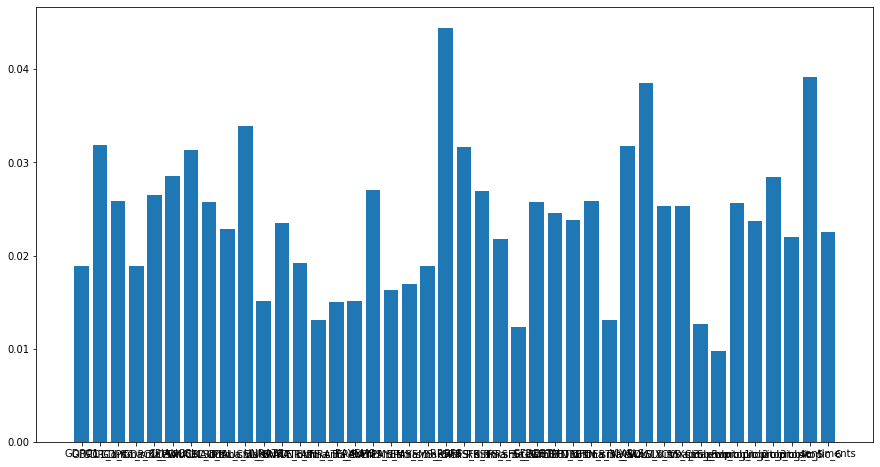

In [19]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(15,8))
plt.bar([final_df.columns[x] for x in range(len(importance))], importance)
plt.show()

#### Information Gain Ratio

In [20]:
cols = final_df.iloc[:, :-1].columns
igr_list = []
for col in cols:
    key_value = [col]
    igr = info_gain.info_gain_ratio(
        final_df['target'].values.tolist(), 
        final_df[col].values.tolist())
    key_value.append(igr)
    igr_list.append(key_value)
igr_list = sorted(igr_list, key=lambda x: x[1], reverse=True)

In [21]:
igr_list

[['GDPC1_sma_5', 0.14660838568517373],
 ['GDPC1_ewm', 0.14660838568517373],
 ['CPIAUCSL_diff', 0.14660838568517373],
 ['CPIAUCSL_ewm', 0.14660838568517373],
 ['UNRATE_ewm', 0.14660838568517373],
 ['PAYEMS_diff', 0.14660838568517373],
 ['PAYEMS_sma_3', 0.14660838568517373],
 ['PAYEMS_ewm', 0.14660838568517373],
 ['RRSFS', 0.14660838568517373],
 ['RRSFS_diff', 0.14660838568517373],
 ['RRSFS_sma_3', 0.14660838568517373],
 ['RRSFS_sma_5', 0.14660838568517373],
 ['RRSFS_ewm', 0.14660838568517373],
 ['GFDEBTN_sma_5', 0.14660838568517373],
 ['GFDEBTN_ewm', 0.14660838568517373],
 ['VIXCLS_diff', 0.14660838568517373],
 ['VIXCLS_ewm', 0.14660838568517373],
 ['prob_topic_1', 0.14660838568517373],
 ['prob_topic_2', 0.14660838568517373],
 ['prob_topic_3', 0.14660838568517373],
 ['prob_topic_4', 0.14660838568517373],
 ['prob_topic_5', 0.14660838568517373],
 ['prob_topic_6', 0.14660838568517373],
 ['VIXCLS_sma_3', 0.14622332939341048],
 ['CPIAUCSL', 0.14622332939341046],
 ['GDPC1', 0.1459978163037512

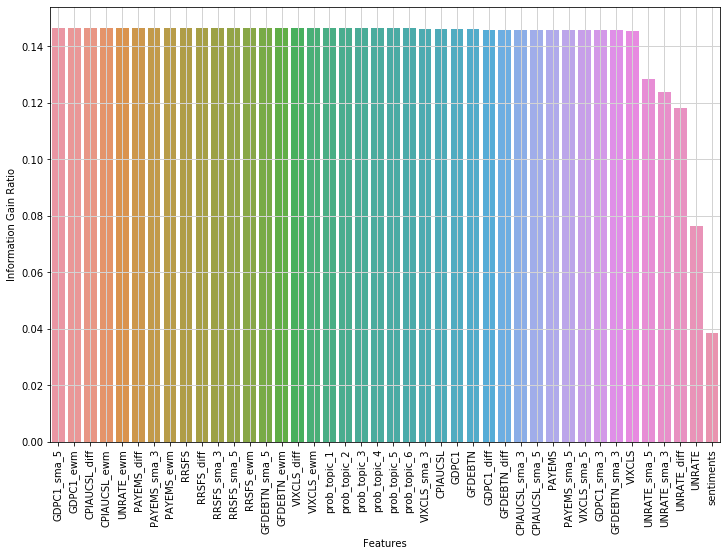

In [22]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x="Features", 
                 y="Information Gain Ratio", 
                 data=pd.DataFrame(igr_list, 
                                   columns=['Features', 
                                            'Information Gain Ratio']))
plt.xticks(rotation='vertical')
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

##### Final Feature Set 1 (Unique Top 5 Features from Each Method)

In [23]:
igr_top_5 = [x[0] for x in igr_list][:5]

In [24]:
vif_top_5 = [i for i in final_df.columns for x in list(selected_features.columns) if i == x][:5]

In [25]:
indices = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_5 = [final_df.columns[x] for x in indices][:5]

In [26]:
final_set = []
for i in igr_top_5:
    if i not in final_set:
        final_set.append(i)
for j in vif_top_5:
    if j not in final_set:
        final_set.append(j)
for k in rf_top_5:
    if k not in final_set:
        final_set.append(k)
final_set

['GDPC1_sma_5',
 'GDPC1_ewm',
 'CPIAUCSL_diff',
 'CPIAUCSL_ewm',
 'UNRATE_ewm',
 'GDPC1_diff',
 'UNRATE_diff',
 'PAYEMS_diff',
 'RRSFS_diff',
 'RRSFS',
 'prob_topic_6',
 'VIXCLS_diff']

##### Final Feature Set 2 (Unique Top 3 Features from Each Method)

In [27]:
igr_top_3 = [x[0] for x in igr_list][:3]

In [28]:
vif_top_3 = [i for i in final_df.columns for x in list(selected_features.columns) if i == x][:3]

In [29]:
indices = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_3 = [final_df.columns[x] for x in indices][:3]

In [30]:
final_set_1 = []
for i in igr_top_3:
    if i not in final_set_1:
        final_set_1.append(i)
for j in vif_top_3:
    if j not in final_set_1:
        final_set_1.append(j)
for k in rf_top_3:
    if k not in final_set_1:
        final_set_1.append(k)
final_set_1

['GDPC1_sma_5',
 'GDPC1_ewm',
 'CPIAUCSL_diff',
 'GDPC1_diff',
 'UNRATE_diff',
 'RRSFS',
 'prob_topic_6',
 'VIXCLS_diff']

##### Final Feature Set 3 (Unique Top 1 Feature from Each Method)

In [31]:
igr_top_1 = [x[0] for x in igr_list][0]

In [32]:
vif_top_1 = [i for i in final_df.columns for x in list(selected_features.columns) if i == x][0]

In [33]:
indices = np.argsort(rf_clf.feature_importances_)[::-1] # increasing order
rf_top_1 = [final_df.columns[x] for x in indices][0]

In [34]:
final_set_2=[igr_top_1, vif_top_1, rf_top_1]

In [35]:
final_set_2=list(set(final_set_2))
final_set_2

['RRSFS', 'GDPC1_diff', 'GDPC1_sma_5']

### Preparing Datasets

##### All Features

In [36]:
X_all = final_df.drop(columns=['target'])
y_all = final_df.target

##### Selected Features (Set 1)

In [37]:
if 'target' not in final_set:
    final_set.append('target')
    
df_fs = final_df[final_set]
X_fs1 = df_fs.drop(columns=['target'])
y_fs1 = df_fs.target

##### Selected Features (Set 2)

In [38]:
if 'target' not in final_set_1:
    final_set_1.append('target')
    
df_fs = final_df[final_set_1]
X_fs2 = df_fs.drop(columns=['target'])
y_fs2 = df_fs.target

In [39]:
data = [('All features', X_all, y_all),
        ('Feature set 1', X_fs1, y_fs1),
        ('Feature set 2', X_fs2, y_fs2)]

##### Selected Features (Set 3)

In [40]:
if 'target' not in final_set_2:
    final_set_2.append('target')
    
df_fs = final_df[final_set_2]
X_fs3 = df_fs.drop(columns=['target'])
y_fs3 = df_fs.target

In [41]:
data = [('All features', X_all, y_all),
        ('Feature set 1', X_fs1, y_fs1),
        ('Feature set 2', X_fs2, y_fs2),
        ('Feature set 3', X_fs3, y_fs3)]

### Stacking and Cross-Validation

#### Stacking Classifiers

In [42]:
base_learners = [("SVC", SVC(random_state=1)),
                 ("Decision Tree", DecisionTreeClassifier(random_state=1)),
                 ("Logistic Regression", LogisticRegression(random_state=1, max_iter=200))]

##### Log Reg as Meta Learner

In [43]:
clf_lr = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(random_state=1, max_iter=200))

##### Decision Tree as Meta Learner

In [44]:
clf_dt = StackingClassifier(estimators=base_learners, final_estimator=DecisionTreeClassifier(random_state=1))

#### TimeSeriesSplit Cross-Validation

In [45]:
classifiers = []
classifiers.extend([("Log Reg as Meta Learner", clf_lr), 
                    ("Decision Tree as Meta Learner", clf_dt)])

In [46]:
results = []
classifier_name = []
dataset = []
for dt in data:
    X = dt[1]
    y = dt[2]
    for clf in classifiers:
        tscv = TimeSeriesSplit(n_splits=5)
        all_y_preds = []
        all_y_true = []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
            y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
            clf[1].fit(X_train, y_train)
            y_preds = clf[1].predict(X_test)
            all_y_preds.extend(y_preds)
            all_y_true.extend(y_test)
        dataset.append(dt[0])
        results.append(f1_score(all_y_true,all_y_preds, average='weighted'))
        classifier_name.append(clf[0])

In [47]:
final_results = pd.DataFrame([dataset, classifier_name, results]).transpose()\
                                                    .rename(columns={0:'Dataset',\
                                                                     1:'Model',\
                                                                     2:'F1-Weighted'})\
                                                    .sort_values(by='F1-Weighted', \
                                                                 ascending=False)\
                                                    .reset_index().iloc[:,1:]
final_results

,Dataset,Model,F1-Weighted
0,Feature set 1,Decision Tree as Meta Learner,0.492452
1,Feature set 2,Decision Tree as Meta Learner,0.407057
2,All features,Log Reg as Meta Learner,0.388764
3,Feature set 3,Decision Tree as Meta Learner,0.353489
4,Feature set 2,Log Reg as Meta Learner,0.333409
5,All features,Decision Tree as Meta Learner,0.312394
6,Feature set 1,Log Reg as Meta Learner,0.307184
7,Feature set 3,Log Reg as Meta Learner,0.234378


Feature set 1: ['GDPC1_sma_5', 'GDPC1_ewm', 'CPIAUCSL_diff',  'CPIAUCSL_ewm', 'UNRATE_ewm', 'GDPC1_diff', 'UNRATE_diff', 'PAYEMS_diff', 'RRSFS_diff', 'RRSFS', 'prob_topic_6', 'VIXCLS_diff']

### Hyperparameter Tuning of Best Model with Grid Search

#### Using only features from Feature Set 1

In [49]:
X = X_fs1
y = y_fs1

#### Setting Hyperparmeter Search Space

In [50]:
params = {'min_samples_leaf' : [2,4,6,8,10,12],
          'max_depth':[1,2,3,4,5]}

#### Grid Search

In [51]:
results = []
minsamplesleaf = []
maxdepth = []
for i in params['min_samples_leaf']:
    for j in params['max_depth']:
        tscv = TimeSeriesSplit(n_splits=5)
        all_y_preds = []
        all_y_true = []
        clf = StackingClassifier(estimators=base_learners, 
                                 final_estimator=DecisionTreeClassifier(min_samples_leaf=i,
                                                                        max_depth=j,
                                                                        random_state=1))
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
            y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
            clf.fit(X_train, y_train)
            y_preds = clf.predict(X_test)
            all_y_preds.extend(y_preds)
            all_y_true.extend(y_test)
        results.append(f1_score(all_y_true,all_y_preds, average='weighted'))
        minsamplesleaf.append(i)
        maxdepth.append(j)

#### Results

In [52]:
tuned_model = pd.DataFrame([results, minsamplesleaf, maxdepth]).transpose()\
                        .rename(columns={0:'F1-Weighted', 
                                         1:'min_samples_leaf', 
                                         2: 'max_depth'})\
                        .sort_values(by='F1-Weighted', 
                                     ascending=False)\
                        .reset_index().iloc[:,1:]
tuned_model

,F1-Weighted,min_samples_leaf,max_depth
0,0.503956,10.0,3.0
1,0.503956,8.0,4.0
2,0.503956,6.0,3.0
3,0.503690,10.0,4.0
4,0.503690,8.0,3.0
5,0.503690,8.0,5.0
6,0.503690,10.0,5.0
7,0.500946,6.0,4.0
8,0.500579,6.0,5.0
9,0.497011,4.0,3.0
